In [1]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import librosa
import soundfile as sf
import os, glob

from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

import time

import random

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import librosa.display as dsp
import mir_eval
from IPython.display import Audio
import matplotlib.pyplot as plt

In [2]:
#function for extracting the features
def extract_feature(file_name):
    X, sample_rate = librosa.load(os.path.join(file_name), res_type='kaiser_best')
    stft=np.abs(librosa.stft(X))
    result=np.array([])
    mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
    result=np.hstack((result,mfccs))
    chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result=np.hstack((result,chroma))
    spectrogram=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
    result=np.hstack((result,spectrogram))
    return result


In [3]:
#for matching filenames with emotion
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
observed_emotions={'calm':0, 'happy':1, 'fearful':2, 'disgust':3}

In [4]:
#function for loading the data
def load_data(filepath): 
    x,g,y,f=[],[],[],[]
    
    # feature to extract
    mfcc = True

    paths = []
    paths.append(filepath)
   
    for path in paths:
        for file in glob.glob(path):
            file_name=os.path.basename(file)
            emotion=emotions[file_name.split("-")[2]] #to get emotion according to filename. dictionary emotions is defined above.
            if emotion not in observed_emotions.keys():
                continue
            if(int(file_name.split("-")[6].split(".")[0])%2):
                g.append("Male")
            else:
                g.append("Female")
            feature=extract_feature(file)
            x.append(feature)
            y.append(emotion)
            f.append(file_name)
    return {"X":x,"g":g,"y":y,"f":f}

In [5]:
#loading the data
def data_processing():
    start_time = time.time()
    Trial_dict = load_data("C:/Users/david/Downloads/archive/Actor_*/*.wav")
    print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))
    #converting to dataframe
    X = pd.DataFrame(Trial_dict["X"])
    g = pd.DataFrame(Trial_dict["g"])
    y = pd.DataFrame(Trial_dict["y"])
    f = pd.DataFrame(Trial_dict["f"])
    #renaming column names
    y=y.rename(columns= {0: 'emotion'})
    g=g.rename(columns= {0: 'gender'})
    f=f.rename(columns= {0: 'filename'})
    #concatenating the dataframes
    data = pd.concat([X, f, g, y], axis =1)
    #for making the data random
    # data = data.reindex(np.random.permutation(data.index))
    #saving data to csv
    data.to_csv('data.csv', index=False)

In [6]:
try:
  data = pd.read_csv("data.csv")
except:
  data_processing()

data = pd.read_csv("data.csv")

--- Data loaded. Loading time: 44.1708710193634 seconds ---


In [7]:
data

,0,1,2,3,4,5,6,7,8,9,...,173,174,175,176,177,178,179,filename,gender,emotion
0,-728.250427,63.978127,1.503606,16.672989,6.537086,3.505902,-4.833341,-2.226708,-11.258503,-3.375772,...,0.000008,0.000004,0.000002,0.000002,7.595593e-07,6.779792e-08,1.358367e-09,03-01-02-01-01-01-01.wav,Male,calm
1,-708.444824,68.275627,0.720012,12.693843,8.231519,2.551562,-5.898926,-3.235186,-9.733943,-3.424062,...,0.000003,0.000003,0.000004,0.000003,1.485640e-06,1.162135e-07,2.015163e-09,03-01-02-01-01-02-01.wav,Male,calm
2,-698.417786,66.880730,-0.836123,15.390104,4.217039,4.619611,-3.044673,-3.098406,-10.319806,-2.937279,...,0.000014,0.000034,0.000052,0.000054,2.374604e-05,1.855033e-06,1.632362e-08,03-01-02-01-02-01-01.wav,Male,calm
3,-699.818726,70.371246,-0.566691,15.343685,6.694068,3.695070,-2.224451,-4.148477,-9.418019,-2.885618,...,0.000020,0.000024,0.000024,0.000015,5.528448e-06,5.825631e-07,1.021049e-08,03-01-02-01-02-02-01.wav,Male,calm
4,-735.483826,72.453140,2.309139,15.769185,7.388165,3.709811,-5.551935,-1.069268,-8.113977,-2.737980,...,0.000001,0.000002,0.000004,0.000003,8.572507e-07,1.085423e-07,1.208249e-09,03-01-02-02-01-01-01.wav,Male,calm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,-569.106567,52.730045,-19.179628,7.030930,-13.469654,-10.614804,-15.646835,-14.295638,-15.181238,-1.810298,...,0.000685,0.000445,0.000253,0.000126,6.542808e-05,1.065850e-05,2.307115e-07,03-01-07-01-02-02-24.wav,Female,disgust
764,-609.862061,55.874176,-12.270983,0.797629,-19.799801,-6.321277,-13.306941,-14.632303,-11.185981,1.281417,...,0.000033,0.000024,0.000016,0.000014,4.633628e-06,4.461181e-07,9.269638e-09,03-01-07-02-01-01-24.wav,Female,disgust
765,-504.026733,33.492260,-25.259033,-0.905644,-17.759993,-8.268425,-17.365608,-9.657678,-6.430394,0.995612,...,0.000471,0.000421,0.000366,0.000234,8.167539e-05,7.214972e-06,9.843457e-08,03-01-07-02-01-02-24.wav,Female,disgust
766,-511.855103,33.078693,-25.351046,-3.669427,-17.204227,-9.845312,-16.486992,-13.139003,-7.608793,-1.511128,...,0.002634,0.002444,0.001352,0.000727,2.639075e-04,3.939355e-05,6.879179e-07,03-01-07-02-02-01-24.wav,Female,disgust


In [8]:
def classify_result(clf,clf_name,X_train, y_train,X_test,y_test):
    print("\n"+clf_name+": \n")
    starting_time = time.time()
    k=5
    kf = KFold(n_splits=k, random_state=None)
    acc_score = []
 
    for train_index , test_index in kf.split(X_train):
        X_training,X_validation =X_train.iloc[train_index,:],X_train.iloc[test_index,:]
        y_training , y_validation = y_train.iloc[train_index,:] , y_train.iloc[test_index,:]
        
     
        clf.fit(X_training,y_training)
        pred_values = clf.predict(X_validation)
     
        acc = accuracy_score(pred_values , y_validation)
        acc_score.append(acc)
     
    avg_acc_score = (sum(acc_score)/k)*100
    print("The cross validation score is %s"%avg_acc_score)
    print("Trained model in %s ms " % str(time.time() - starting_time))
    y_train_pred= clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    #printing classification report, accuracy and confusion matrix
    print(classification_report(y_test,y_test_pred))

    test_acc = float(accuracy_score(y_test,y_test_pred))*100
    train_acc=float(accuracy_score(y_train,y_train_pred))*100
    print("----Training accuracy score %s ----" % train_acc)
    print("----Accuracy score %s ----" % test_acc)
    cross_val_dict[clf_name]=avg_acc_score
    train_acc_dict[clf_name]=train_acc
    test_acc_dict[clf_name]=test_acc
    cm = confusion_matrix(y_test,y_test_pred)
    df_cm = pd.DataFrame(cm)
    title="Confusion matrix for "+clf_name
    plt.figure()
    plt.title(title)
    sns.heatmap(df_cm, annot=True, fmt='')
    plt.savefig('images/confusion/'+clf_name+'.png')

In [9]:
#fitting a random forest classifier
from sklearn.ensemble import RandomForestClassifier
def randomforest(X_train, y_train,X_test,y_test):
    clf = RandomForestClassifier(n_estimators=200,criterion='gini',max_features='sqrt',max_depth=15, random_state=0)
    classify_result(clf,"Random Forest",X_train, y_train,X_test,y_test)

In [10]:
# X_train=X_train.to_numpy()
# y_train=y_train.to_numpy()
# y_train=y_train.flatten()
# X_test=X_test.to_numpy()
# y_test=y_test.to_numpy()
# y_test=y_test.flatten()

In [11]:
# from sklearn.model_selection import KFold
# from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
# import torch
# clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
#                        optimizer_params=dict(lr=1e-3),
#                        scheduler_params={"step_size":10, "gamma":0.9},
#                        scheduler_fn=torch.optim.lr_scheduler.StepLR,
#                        mask_type='entmax' ) 
# clf.fit(
#   X_train, y_train,eval_metric=['accuracy'],
#                max_epochs=1000 , patience=50,
#                batch_size=28, drop_last=False
# )
# y_train_pred= clf.predict(X_train)
# y_pred = clf.predict(X_test)
# #printing classification report, accuracy and confusion matrix
# print(classification_report(y_test,y_pred))

# acc = float(accuracy_score(y_test,y_pred))*100
# train_acc=float(accuracy_score(y_train,y_train_pred))*100
# print("----Training accuracy score %s ----" % train_acc)
# print("----Accuracy score %s ----" % acc)
# train_acc_dict["Tabnet"]=train_acc
# test_acc_dict["Tabnet"]=acc
# cm = confusion_matrix(y_test,y_pred)
# df_cm = pd.DataFrame(cm)
# sns.heatmap(df_cm, annot=True, fmt='')

In [12]:
from sklearn.neural_network import MLPClassifier
def MLP(X_train, y_train,X_test,y_test):
    clf = MLPClassifier(alpha=0.01, batch_size=256,epsilon=1e-08,hidden_layer_sizes=(300,),learning_rate='adaptive',max_iter=500,random_state=0)
    classify_result(clf,"Multi Layer Perceptron",X_train, y_train,X_test,y_test)

In [13]:
from sklearn.neighbors import KNeighborsClassifier
def KNN(X_train, y_train,X_test,y_test):
    clf = KNeighborsClassifier(n_neighbors=5,weights='distance')
    classify_result(clf,"K Neighbors",X_train, y_train,X_test,y_test)

In [14]:
from sklearn.svm import SVC
def SVM(X_train, y_train,X_test,y_test):
    clf =SVC(kernel="linear", C=0.025)
    classify_result(clf,"Support Vector Machine",X_train, y_train,X_test,y_test)

In [15]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
def GaussianProcess(X_train, y_train,X_test,y_test):
    kernel = 1.0 * RBF(1.0)

    clf = GaussianProcessClassifier(kernel=kernel,random_state=0,multi_class='one_vs_one')
    classify_result(clf,"Gaussian Process Classifier",X_train, y_train,X_test,y_test)

In [16]:
from xgboost import XGBClassifier
def XGB(X_train, y_train,X_test,y_test):
    clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',eta=0.1)
    classify_result(clf,"XG Boost",X_train, y_train,X_test,y_test)

In [17]:
def modelling(data):
    #data=data.replace({"emotion": observed_emotions})

    from sklearn import preprocessing
    label_encoder = preprocessing.LabelEncoder()
    data['emotion']= label_encoder.fit_transform(data['emotion'])
    label_encoder = preprocessing.LabelEncoder()
    data['gender']= label_encoder.fit_transform(data['gender'])
    
    #splitting to features and target variables
    X=data.drop(["emotion","gender","filename"],axis=1)
    y=data.iloc[:,-1:]

    #splitting into test and train sets
    X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.20, random_state=42)

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    X_train = pd.DataFrame(X_train, columns = X.columns)
    X_test = pd.DataFrame(X_test, columns = X.columns)

    # from sklearn.preprocessing import MinMaxScaler
    # scaler = MinMaxScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)
    
    # mean = np.mean(X_train, axis=0)
    # std = np.std(X_train, axis=0)
    # X_train = (X_train - mean)/std
    # X_test = (X_test - mean)/std

    X_train = pd.DataFrame(X_train, columns = X.columns)
    X_test = pd.DataFrame(X_test, columns = X.columns)
    
    randomforest(X_train, y_train,X_test,y_test)
    MLP(X_train, y_train,X_test,y_test)
    KNN(X_train, y_train,X_test,y_test)
    SVM(X_train, y_train,X_test,y_test)
    GaussianProcess(X_train, y_train,X_test,y_test)
    XGB(X_train, y_train,X_test,y_test)

    print("\nTraining accuracy:\n")
    print ("{:<30} {:<10}".format('Model','Training Accuracy'))
    for k, v in train_acc_dict.items():
        score = v
        print ("{:<30} {:<10}".format(k,v))
    print("\nTesting accuracy:\n")
    print ("{:<30} {:<10}".format('Model','Testing Accuracy'))
    for k, v in test_acc_dict.items():
        score = v
        print ("{:<30} {:<10}".format(k,v))
    print("\nCross Validation Score:\n")
    print ("{:<30} {:<10}".format('Model','Cross val score'))
    for k, v in cross_val_dict.items():
        score = v
        print ("{:<30} {:<10}".format(k,v))


Random Forest: 

The cross validation score is 66.947887511662
Trained model in 2.4812140464782715 ms 
              precision    recall  f1-score   support

           0       0.78      0.90      0.83        39
           1       0.59      0.68      0.63        38
           2       0.66      0.54      0.59        39
           3       0.61      0.53      0.56        38

    accuracy                           0.66       154
   macro avg       0.66      0.66      0.66       154
weighted avg       0.66      0.66      0.66       154

----Training accuracy score 94.62540716612378 ----
----Accuracy score 66.23376623376623 ----

Multi Layer Perceptron: 

The cross validation score is 76.7146474743436
Trained model in 5.778538703918457 ms 
              precision    recall  f1-score   support

           0       0.91      0.74      0.82        39
           1       0.73      0.79      0.76        38
           2       0.67      0.72      0.69        39
           3       0.59      0.61     

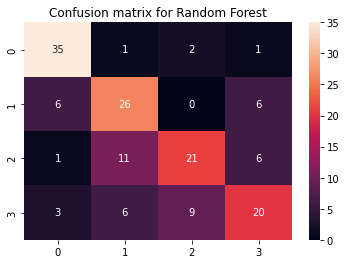

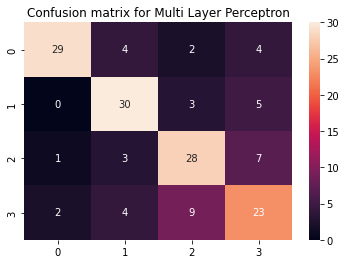

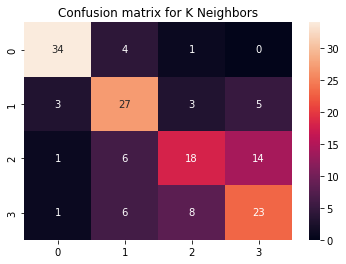

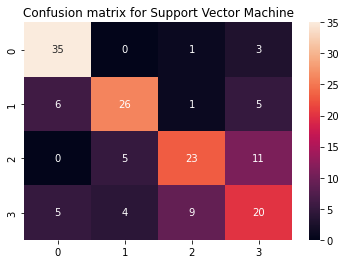

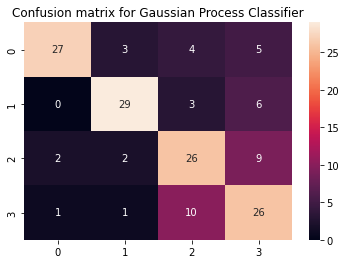

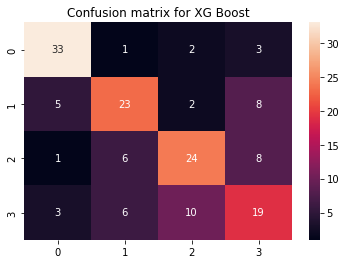

In [18]:
cross_val_dict={}
train_acc_dict={}
test_acc_dict={}
modelling(data)

In [19]:
#Data Augmentation
def add_white_noise(signal, noise_percentage_factor):
    noise = np.random.normal(0, signal.std(), signal.size)
    augmented_signal = signal + noise * noise_percentage_factor
    return augmented_signal


def time_stretch(signal, time_stretch_rate):
    """Time stretching implemented with librosa:
    https://librosa.org/doc/main/generated/librosa.effects.pitch_shift.html?highlight=pitch%20shift#librosa.effects.pitch_shift
    """
    return librosa.effects.time_stretch(signal, time_stretch_rate)


def pitch_scale(signal, sr, num_semitones):
    """Pitch scaling implemented with librosa:
    https://librosa.org/doc/main/generated/librosa.effects.pitch_shift.html?highlight=pitch%20shift#librosa.effects.pitch_shift
    """
    return librosa.effects.pitch_shift(signal, sr, num_semitones)


def random_gain(signal, min_factor=0.5, max_factor=2):
    gain_rate = random.uniform(min_factor, max_factor)
    #gain_rate = min_factor
    augmented_signal = signal * gain_rate
    return augmented_signal


def invert_polarity(signal):
    return signal * -1

In [20]:
def augmenting(train_filename_list):
    paths = []
    paths.append("C:/Users/david/Downloads/archive/Actor_*/*.wav")
   
    for path in paths:
        for file in glob.glob(path):
            file_name = os.path.basename(file)
            if file_name not in train_filename_list:
                continue
            emotion = emotions[file_name.split("-")[2]] #to get emotion according to filename. dictionary emotions is defined above.
            if emotion not in observed_emotions.keys():
                continue
            X, sample_rate = librosa.load(os.path.join(file), res_type='kaiser_best')
            augmented_signal = add_white_noise(X, 0.1)
            augmented_signal = time_stretch(augmented_signal, 0.5)
            #augmented_signal = pitch_scale(augmented_signal, sample_rate, 2)
            augmented_signal = random_gain(augmented_signal)
            augmented_signal = invert_polarity(augmented_signal)
            sf.write("Augmented/augmented"+file_name, augmented_signal, sample_rate)

In [21]:
def augmented_data_processing():
    start_time = time.time()
    Trial_dict = load_data("C:/Users/david/Downloads/dissertation/Augmented/*.wav")
    print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))
    #converting to dataframe
    X = pd.DataFrame(Trial_dict["X"])
    g = pd.DataFrame(Trial_dict["g"])
    y = pd.DataFrame(Trial_dict["y"])
    #renaming column names
    y=y.rename(columns= {0: 'emotion'})
    g=g.rename(columns= {0: 'gender'})
    #concatenating the dataframes
    augmented_data = pd.concat([X, g, y], axis =1)
    #for making the data random
    # augmented_data = augmented_data.reindex(np.random.permutation(data.index))
    #saving data to csv
    augmented_data.to_csv('augmented_data.csv', index=False)
    return augmented_data

In [22]:
# try:
#   augmented_data = pd.read_csv("augmented_data.csv")
# except:
#   augmented_data_processing()

# augmented_data = pd.read_csv("augmented_data.csv")

In [23]:
def augmented_modelling():
    data = pd.read_csv("data.csv")
    
    #data=data.replace({"emotion": observed_emotions})

    from sklearn import preprocessing
    label_encoder_emotion = preprocessing.LabelEncoder()
    data['emotion']= label_encoder_emotion.fit_transform(data['emotion'])
    label_encoder_gender = preprocessing.LabelEncoder()
    data['gender']= label_encoder_gender.fit_transform(data['gender'])
    
    #splitting to features and target variables
    X=data.drop(["emotion","gender"],axis=1)
    y=data.iloc[:,-1:]
    
    #splitting into test and train sets
    X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.20, random_state=42)
    
    train_filename_list = X_train["filename"].values.tolist()
    X_train = X_train.drop("filename",axis=1)
    X_test = X_test.drop("filename",axis=1)
    
    augmenting(train_filename_list)
    augmented_data = augmented_data_processing()
    
    augmented_data['emotion']= label_encoder_emotion.transform(augmented_data['emotion'])
    
    augmented_data['gender']= label_encoder_gender.transform(augmented_data['gender']) 
    
    X_augmented=augmented_data.drop(["emotion","gender"],axis=1)
    y_augmented=augmented_data.iloc[:,-1:]

    X_augmented.columns=X_train.columns
    X_train = pd.concat([X_train, X_augmented])
    y_train = pd.concat([y_train, y_augmented])
    
    columns=X_train.columns
    
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # from sklearn.preprocessing import MinMaxScaler
    # scaler = MinMaxScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)
    
    # mean = np.mean(X_train, axis=0)
    # std = np.std(X_train, axis=0)
    # X_train = (X_train - mean)/std
    # X_test = (X_test - mean)/std
    
    X_train = pd.DataFrame(X_train, columns = columns)
    X_test = pd.DataFrame(X_test, columns = columns)
    
    randomforest(X_train, y_train,X_test,y_test)
    MLP(X_train, y_train,X_test,y_test)
    KNN(X_train, y_train,X_test,y_test)
    SVM(X_train, y_train,X_test,y_test)
    GaussianProcess(X_train, y_train,X_test,y_test)
    XGB(X_train, y_train,X_test,y_test)
    print("\nTraining accuracy:\n")
    print ("{:<30} {:<10}".format('Model','Training Accuracy'))
    for k, v in train_acc_dict.items():
        score = v
        print ("{:<30} {:<10}".format(k,v))
    print("\nTesting accuracy:\n")
    print ("{:<30} {:<10}".format('Model','Testing Accuracy'))
    for k, v in test_acc_dict.items():
        score = v
        print ("{:<30} {:<10}".format(k,v))
    print("\nCross Validation Score:\n")
    print ("{:<30} {:<10}".format('Model','Cross val score'))
    for k, v in cross_val_dict.items():
        score = v
        print ("{:<30} {:<10}".format(k,v))

--- Data loaded. Loading time: 30.669403553009033 seconds ---

Random Forest: 

The cross validation score is 43.26663348266136
Trained model in 4.980027914047241 ms 
              precision    recall  f1-score   support

           0       0.74      0.90      0.81        39
           1       0.57      0.53      0.55        38
           2       0.67      0.56      0.61        39
           3       0.54      0.55      0.55        38

    accuracy                           0.64       154
   macro avg       0.63      0.64      0.63       154
weighted avg       0.63      0.64      0.63       154

----Training accuracy score 80.86319218241043 ----
----Accuracy score 63.63636363636363 ----

Multi Layer Perceptron: 

The cross validation score is 57.92135390741663
Trained model in 13.441518068313599 ms 
              precision    recall  f1-score   support

           0       1.00      0.79      0.89        39
           1       0.76      0.82      0.78        38
           2       0.70    

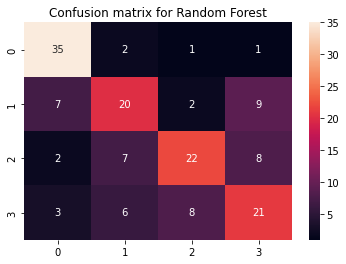

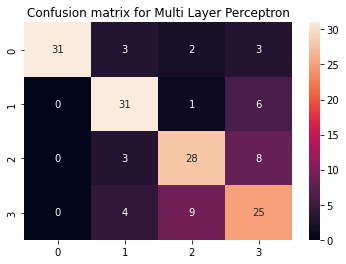

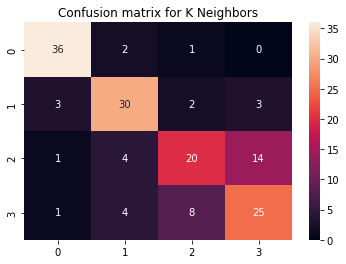

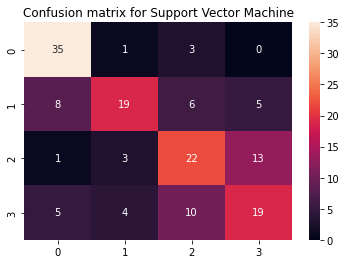

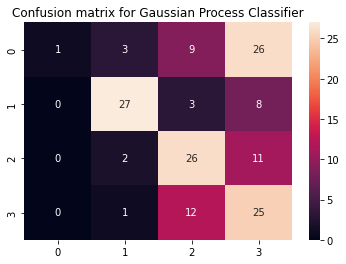

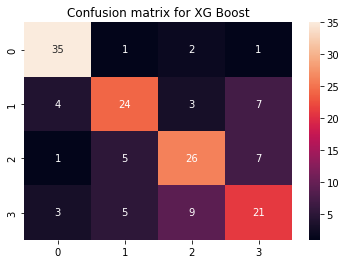

In [24]:
cross_val_dict={}
train_acc_dict={}
test_acc_dict={}
augmented_modelling()

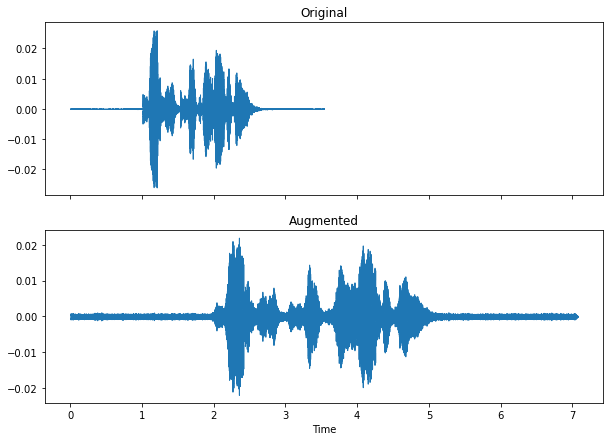

In [25]:
import librosa.display as dsp
import mir_eval
from IPython.display import Audio
import matplotlib.pyplot as plt

data1, sample_rate = librosa.load("C:/Users/david/Downloads/archive/Actor_01/03-01-02-01-01-01-01.wav",res_type='kaiser_fast')
data2, sample_rate = librosa.load("C:/Users/david/OneDrive/Desktop/Coursework/Dissertation/Augmented/augmented03-01-02-01-01-01-01.wav",res_type='kaiser_fast')
fig, ax = plt.subplots(nrows=2, sharex=True,figsize=(10,7))
librosa.display.waveshow(data1, sr=sample_rate, ax=ax[0])
ax[0].set(title='Original')
ax[0].label_outer()
librosa.display.waveshow(data2, sr=sample_rate, ax=ax[1])
ax[1].set(title='Augmented')
ax[1].label_outer()

plt.savefig('images/dataaugmentation.png')